## Refining EMP metadata (QIIME mapping files) using Pandas

### Columns in the refined mapping files

The following columns are created in the merged and individual refined mapping files.

_Sample_

* `#SampleID` -- no changes needed
* `BarcodeSequence` -- no changes needed
* `LinkerPrimerSequence` -- no changes needed
* `Description` -- no changes needed
* `host_subject_id` -- no changes needed

_Study_

* `study_id` -- parsed from SampleID
* `title` -- using most updated titles (from `emp_studies_quality.xlsx`)
* `ebi_accession` -- EBI accession number if submitted (from `emp_studies_quality.xlsx`)
* `emp_paper` -- included among 97 studies in 2016 EMP paper (TRUE/FALSE, from `emp_studies_quality.xlsx`)
* `study_ok` -- study does not have major issues (from `emp_studies_quality.xlsx`)
* `dense_sampling` -- whether the study has highly similar samples (from `emp_studies_quality.xlsx`)
* `metadata_minimal` -- whether the study has only minimal metadata (from `emp_studies_quality.xlsx`)
* `units_status` -- whether units are provided for measurements (from `emp_studies_quality.xlsx`)

_Sequences_

* `sequences_per_sample` -- number of sequences per sample after split libraries (from `emp_observations_97studies.tsv`)
* `deblur_90bp_observations` -- number of observations in 90-bp Deblur table having phylum-level taxonomy (indicates true bacterial/archaeal OTU)

_Subsample_

* `all_emp` -- samples with >=1 sequences per sample
* `qc_filtered` -- samples with >=1000 sequences per sample but not controls (all subsets are in this set)
* `subset_10000` -- 10000 samples with >=10000 deblur_90bp_onlyphylum counts, evenly distributed across `empo_3` categories and then across studies
* `subset_5000` -- 5000 samples with >=10000 deblur_90bp_onlyphylum counts, evenly distributed across `empo_3` categories and then across studies
* `subset_2000` -- 2000 samples with >=10000 deblur_90bp_onlyphylum counts, evenly distributed across `empo_3` categories and then across studies

_Taxonomy_

* `sample_taxid` -- removed trailing ".0", fixed Excel Auto Fill and other typos
* `sample_scientific_name` -- looked up from names.dmp using `sample_taxid`
* `host_taxid` -- removed trailing ".0", fixed many errors
* `host_common_name_provided` -- kept but see lookup value, deleted if refers to sample
* `host_common_name` -- looked up from names.dmp using `host_taxid`
* `host_scientific_name` -- looked up from names.dmp using `host_taxid`
* `host_superkingdom` -- looked up from NCBI taxonomy
* `host_kingdom` -- looked up from NCBI taxonomy
* `host_phylum` -- looked up from NCBI taxonomy
* `host_class` -- looked up from NCBI taxonomy
* `host_order` -- looked up from NCBI taxonomy
* `host_family` -- looked up from NCBI taxonomy
* `host_genus` -- looked up from NCBI taxonomy
* `host_species` -- looked up from NCBI taxonomy

_Geography_

* `collection_timestamp` -- removed timestamps after today's date
* `country` -- fixed misspellings
* `latitude_deg` -- fixed errors
* `longitude_deg` -- fixed errors
* `depth_m` -- no changes made
* `altitude_m` -- no changes made
* `elevation_m` -- no changes made

_Ontology_

* `env_biome` -- fixed errors
* `env_feature` -- no changes made -- need additional changes from gDoc
* `env_material` -- fixed errors, changed name from `env_matter` -- need additional changes from gDoc
* `envo_biome_1` -- level 1 envo biome from `envo_biome_name_is_a.txt`
* `envo_biome_2` -- level 2 envo biome from `envo_biome_name_is_a.txt`
* `envo_biome_3` -- level 3 envo biome from `envo_biome_name_is_a.txt`
* `envo_biome_4` -- level 4 envo biome from `envo_biome_name_is_a.txt`
* `envo_biome_5` -- level 5 envo biome from `envo_biome_name_is_a.txt`
* `envo_biome_6` -- level 6 envo biome from `envo_biome_name_is_a.txt`
* `empo_0` -- no changes, inherited from `emp_qiime_mapping_sampletype_unique_empo.xlsx`
* `empo_1` -- no changes, inherited from `emp_qiime_mapping_sampletype_unique_empo.xlsx`
* `empo_2` -- no changes, inherited from `emp_qiime_mapping_sampletype_unique_empo.xlsx`
* `empo_3` -- no changes, inherited from `emp_qiime_mapping_sampletype_unique_empo.xlsx`

_Environment_

* `temperature_deg_c` -- using `temp`, `temp_environment`, made fully numeric
* `ph` -- using `ph` (fixed), `ph_cacl2`, `sediment_ph`, made fully numeric
* `salinity_psu` -- using `salinity`, `samp_salinity`, `sediment_salinity`, made fully numeric
* `oxygen_mg_per_l` -- no changes made
* `nitrogen spp.`
* `phosphorus spp.`
* `carbon spp.`


### Initial setup

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import datetime
from ete2 import NCBITaxa
from collections import defaultdict

In [2]:
# set pandas options
pd.set_option("display.max_rows", 200)
pd.options.mode.chained_assignment = None

In [3]:
# get today's date (used in several parts of the notebook)
today = datetime.datetime.today()

In [4]:
# paths to input files
path_studies = '/Users/luke/emp/metadata-refine/refine_emp_studies_ct112.txt'
path_mapping = '/Users/luke/emp/metadata-qiime-mapping'
path_taxonomy = '/Users/luke/emp/ontology-ncbi-taxonomy/taxdump/names.dmp'
path_empo = '/Users/luke/emp/metadata-refine/empo_samples_unique.xlsx'
path_quality = '/Users/luke/emp/metadata-refine/emp_studies_quality.xlsx'
path_observations = '/Users/luke/emp/otu-picking/emp_observations.tsv'
path_subsample = '/Users/luke/emp/metadata-refine/modMapping_20160831.txt'
path_envobiome = '/Users/luke/emp/ontology-envo/envo_biome_name_is_a.txt'
path_outputdir = '/Users/luke/emp/metadata-refine'

### Functions

#### Merge mapping files and tally column headers

In [5]:
def merge_and_tally_mapping_files(path_studies, path_mapping):
    studies = [line.rstrip('\n') for line in open(path_studies)]
    header_counts = defaultdict(int)
    df_merged = pd.DataFrame()
    for study in studies:
        path = '%s/%s_qiime_mapping.tsv' % (path_mapping, study)
        df_single = pd.read_csv(path, sep='\t', header=0, index_col=0, dtype=str)
        for header in df_single.columns:
            header_counts[header] += 1
        df_merged = df_merged.append(df_single, ignore_index=False, verify_integrity=True)
    return df_merged, header_counts

#### ENVO hierarchy lookup

In [6]:
def term_to_envo_hierarchy(term, dictionary):
    hierarchy = [term]
    while True:
        hierarchy.insert(0, dictionary[term])
        term = dictionary[term]
        if term not in dictionary.keys():
            break
    return hierarchy

def term_parent_to_dict(path):
    # read envo biome file, split into two dataframes, merge, create dictionary
    df = pd.read_csv(path, header=None)
    # name dataframe
    df_name = df.iloc[np.arange(0,df.shape[0],2)]
    df_name.reset_index(inplace=True, drop=True)
    for index, row in df_name.iterrows():
        df_name.iloc[index] = re.sub('name: ', '', str(row[0]))
    # is_a dataframe
    df_is_a = df.iloc[np.arange(1,df.shape[0],2)]
    df_is_a.reset_index(inplace=True, drop=True)
    for index, row in df_is_a.iterrows():
        df_is_a.iloc[index] = re.sub('is_a: ', '', str(row[0]))
    # merged dataframe
    df_name_is_a = pd.merge(df_name, df_is_a, left_index=True, right_index=True)
    df_name_is_a.columns = ['name', 'is_a']
    # dictionary for lookup
    dictionary = dict(zip(df_name_is_a.name, df_name_is_a.is_a))
    return dictionary

#### Remove trailing ".0" from numeric value in column of df (convert string-float to string-int)

In [7]:
def remove_decimal_zero(df, column):
    return [re.sub(r'\.0', '', x) if x is not np.nan else '' for x in df[column]]

#### Round to hundredths with df.apply(round_hundredths)

In [8]:
def round_hundredths(x):
    x = float(x)
    if np.isnan(x):
        return x
    else:
        return "%.2f" % x

#### Convert Fahrenheit to Celsius

In [9]:
def fahrenheit_to_celsius(x):
    x = float(x)
    if np.isnan(x):
        return x
    else:
        return str((x-32)*5/9)

#### Get NCBI taxonomy path -- https://github.com/tanaes/script_bin/blob/master/humann2_full_tax.py#L170

In [10]:
def get_taxon_path(taxid, ncbi, ranks=['superkingdom','kingdom','phylum','class','order','family','genus','species'], rank_headers=['sk__','k__','p__','c__','o__','f__','g__','s__']):

    if rank_headers is None:
        rank_headers = ['' for x in ranks]

    tax_path = [x for x in rank_headers]

    lineage = ncbi.get_lineage(taxid)

    lineage_ranks = ncbi.get_rank(lineage)
    lineage_names = ncbi.get_taxid_translator(lineage)

    for level in range(len(lineage)):
        level_id = lineage[level]
        if lineage_ranks[level_id] in ranks:
            tax_path[ranks.index(lineage_ranks[level_id])] += lineage_names[level_id].replace(' ','_')

    return(tax_path)

### Read input files and make dictionaries

#### Study quality

In [11]:
df_quality = pd.read_excel(path_quality, index_col=None, dtypes=object)

In [12]:
# dictionaries of study_id => title, ebi_accession, emp_paper, dense_sampling, metadata_minimal, units_status, study_ok
dict_title = dict(zip(df_quality.study_id.astype(str), df_quality.title))
dict_ebi_accession = dict(zip(df_quality.study_id.astype(str), df_quality.ebi_accession))
dict_emp_paper = dict(zip(df_quality.study_id.astype(str), df_quality.emp_paper))
dict_dense_sampling = dict(zip(df_quality.study_id.astype(str), df_quality.dense_sampling))
dict_metadata_minimal = dict(zip(df_quality.study_id.astype(str), df_quality.metadata_minimal))
dict_units_status = dict(zip(df_quality.study_id.astype(str), df_quality.units_status))
dict_study_ok = dict(zip(df_quality.study_id.astype(str), df_quality.study_ok))

#### Sequences per sample

In [13]:
df_observations = pd.read_csv(path_observations, sep='\t', index_col=None)
df_observations['deblur_90bp_observations'] = df_observations['deblur_90bp_onlyphylum'].fillna(0.0).astype(int)

In [14]:
# dictionaries of #SampleID => split_libraries, deblur_90bp_onlyphylum
dict_seqs_per_sample = dict(zip(df_observations['#SampleID'], df_observations.split_libraries))
dict_deblur_90bp = dict(zip(df_observations['#SampleID'], df_observations.deblur_90bp_onlyphylum))

#### Subsampled studies

In [15]:
# dictionaries of #SampleID => subsets
df_subsample = pd.read_csv(path_subsample, sep='\t', index_col=None)
dict_allemp = dict(zip(df_subsample['#SampleID'], df_subsample.all_emp))
dict_qcfiltered = dict(zip(df_subsample['#SampleID'], df_subsample.qc_filtered))
dict_subset2000 = dict(zip(df_subsample['#SampleID'], df_subsample.subset_2000))
dict_subset5000 = dict(zip(df_subsample['#SampleID'], df_subsample.subset_5000))
dict_subset10000 = dict(zip(df_subsample['#SampleID'], df_subsample.subset_10000))

#### NCBI taxonomy

In [16]:
# parsing names.dmp file from http://ftp.ncbi.nlm.nih.gov
# delimiter is tab-bar-tab or tab-bar
df_tax = pd.read_csv(path_taxonomy, sep='\t\|\t|\t\|', engine='python', header=None)
# remove last column which is NaN
del df_tax[4]
# rename columns and change tax_id to string
df_tax.columns = ['tax_id', 'name_txt', 'unique_name', 'name_class']
df_tax['tax_id'] = df_tax['tax_id'].astype(str)

In [17]:
# dictionary of tax_id => genbank common name
df_tax_gcn = df_tax[df_tax['name_class'] == 'genbank common name']
dict_gcn = dict(zip(df_tax_gcn.tax_id, df_tax_gcn.name_txt))

In [18]:
# dictionary of tax_id => scientific name
df_tax_sn = df_tax[df_tax['name_class'] == 'scientific name']
dict_sn = dict(zip(df_tax_sn.tax_id, df_tax_sn.name_txt))

### Read and refine mapping file

#### Read mapping files, tally column headers, and merge into single dataframe

In [19]:
# main code to merge mapping files and count how often column headers appear (~5 min)
df_merged, header_counts = merge_and_tally_mapping_files(path_studies, path_mapping)

In [20]:
# change spaces in indexes to periods (for study 905)
df_merged.index = [re.sub(' ', '.', x) for x in df_merged.index]

In [21]:
# add study_id
df_merged['study_id'] = [re.split(r'\.', x)[0] for x in df_merged.index]

#### Add EMPO columns to merged all columns and select columns (and covert indexes to lowercase to match biom)

In [22]:
# make empo dataframe
df_empo = pd.read_excel(path_empo, index_col=0, dtypes=object)
df_empo.study_id = df_empo.study_id.astype(str)
# chose columns to define unique rows for empo assignment
sampletype_cols = [
    'study_id',
    'env_biome',
    'env_feature',
    'env_matter',
    'sample_type']
# add empo to union of all mapping files
df_union_empo = pd.merge(df_merged, df_empo, how='left', left_on=sampletype_cols, right_on=sampletype_cols)
df_union_empo.index = [x for x in df_merged.index]
# save union of all mapping files
df_union_empo.to_csv('/Users/luke/emp/metadata-refine/emp_qiime_mapping_union_empo.tsv', sep='\t', index_label='#SampleID')

### Create dataframe for refined columns

#### Sample metadata

In [23]:
# initialize merged dataframe with first 5 columns (no changes)
df_refined = pd.DataFrame(index=df_merged.index)
df_refined.index.name = '#SampleID'
df_refined = df_refined.join(df_merged[['BarcodeSequence', 'LinkerPrimerSequence', 'Description', 'host_subject_id']])

#### Study metadata

In [24]:
# adding columns: study_id, title, ebi_accession, emp_paper
df_refined['study_id'] = [re.split(r'\.', x)[0] for x in df_merged.index]
df_refined['title'] = [dict_title[x] if x in dict_title else '' for x in df_refined['study_id']]
df_refined['ebi_accession'] = [dict_ebi_accession[x] if x in dict_ebi_accession else '' for x in df_refined['study_id']]
df_refined['emp_paper'] = [dict_emp_paper[x] if x in dict_emp_paper else '' for x in df_refined['study_id']]
df_refined['study_ok'] = [dict_study_ok[x] if x in dict_study_ok else '' for x in df_refined['study_id']]

#### Quality metadata

In [25]:
# adding columns: dense_sampling, metadata_minimal, units_status, sequences_per_sample, study_ok
df_refined['dense_sampling'] = [dict_dense_sampling[x] if x in dict_dense_sampling else '' for x in df_refined['study_id']]
df_refined['metadata_minimal'] = [dict_metadata_minimal[x] if x in dict_metadata_minimal else '' for x in df_refined['study_id']]
df_refined['units_status'] = [dict_units_status[x] if x in dict_units_status else '' for x in df_refined['study_id']]
df_refined['study_ok'] = [dict_study_ok[x] if x in dict_study_ok else '' for x in df_refined['study_id']]

#### Sequences metadata

In [26]:
df_refined['sequences_per_sample'] = [dict_seqs_per_sample[x] if x in dict_seqs_per_sample else '' for x in df_refined.index]
df_refined['deblur_90bp_onlyphylum'] = [dict_deblur_90bp[x] if x in dict_deblur_90bp else '' for x in df_refined.index]

#### Subsample metadata

In [27]:
df_refined['all_emp'] = [dict_allemp[x] if x in dict_allemp else '' for x in df_refined.index]
df_refined['qc_filtered'] = [dict_qcfiltered[x] if x in dict_qcfiltered else '' for x in df_refined.index]
df_refined['subset_10000'] = [dict_subset10000[x] if x in dict_subset10000 else '' for x in df_refined.index]
df_refined['subset_5000'] = [dict_subset5000[x] if x in dict_subset5000 else '' for x in df_refined.index]
df_refined['subset_2000'] = [dict_subset2000[x] if x in dict_subset2000 else '' for x in df_refined.index]

#### Taxonomy metadata

##### Sample taxonomy

In [28]:
df_refined['sample_taxid'] = df_merged['taxon_id']

In [29]:
# sample_taxid -- remove trailing ".0"
df_refined['sample_taxid'] = remove_decimal_zero(df_refined, 'sample_taxid')
# sample_taxid -- fix Excel Auto Fill typos
# Study ??
df_refined['sample_taxid'][df_merged['taxon_id'] == '718309'] = '718308'
df_refined['sample_taxid'][df_merged['taxon_id'] == '718310'] = '718308'
df_refined['sample_taxid'][df_merged['taxon_id'] == '718311'] = '718308'
df_refined['sample_taxid'][df_merged['taxon_id'] == '718312'] = '718308'
df_refined['sample_taxid'][df_merged['taxon_id'] == '718313'] = '718308'
df_refined['sample_taxid'][df_merged['taxon_id'] == '718314'] = '718308'
df_refined['sample_taxid'][df_merged['taxon_id'] == '718315'] = '718308'
df_refined['sample_taxid'][df_merged['taxon_id'] == '718316'] = '718308'
df_refined['sample_taxid'][df_merged['taxon_id'] == '718317'] = '718308'
# Study 10145 -- beach sand metagenome should be 412757
df_refined['sample_taxid'][(df_merged['taxon_id'] == '412758') & (df_refined['study_id'] == '10145')] = '412757'
df_refined['sample_taxid'][(df_merged['taxon_id'] == '412760') & (df_refined['study_id'] == '10145')] = '412757'
df_refined['sample_taxid'][(df_merged['taxon_id'] == '412762') & (df_refined['study_id'] == '10145')] = '412757'
# Study 10278 -- peat metagenome should be 1799672
df_refined['sample_taxid'][df_refined['study_id'] == '10278'] = '1799672'
# Study 2192 -- redefine sample_taxid based on #SampleID
for site in ['Bathroom.Door.Knob',
             'Bedroom.Floor',
             'Front.Door.Knob',
             'Kitchen.Counter', 
             'Kitchen.Floor',
             'Kitchen.Light.Switch']:
    site_index = pd.Series(df_refined.index).str.extract(r'(2192\.[A-Za-z0-9]+\.%s\.[0-9]+.*)' % site, expand=False).dropna()
    df_refined['sample_taxid'][site_index] = '1256227' # indoor metagenome
for site in ['Dog.Foot',
             'Cat.Fur',
             'Cat.Paw']:
    site_index = pd.Series(df_refined.index).str.extract(r'(2192\.[A-Za-z0-9]+\.%s\.[0-9]+.*)' % site, expand=False).dropna()
    df_refined['sample_taxid'][site_index] = '1338477' # skin metagenome
for site in ['Dog.Nose']:
    site_index = pd.Series(df_refined.index).str.extract(r'(2192\.[A-Za-z0-9]+\.%s\.[0-9]+.*)' % site, expand=False).dropna()
    df_refined['sample_taxid'][site_index] = '1115523' # upper respiratory tract metagenome
for site in ['Nose']:
    site_index = pd.Series(df_refined.index).str.extract(r'(2192\.[A-Za-z0-9]+\.%s\.[0-9]+.*)' % site, expand=False).dropna()
    df_refined['sample_taxid'][site_index] = '1131769' # human nasal/pharyngeal metagenome
for site in ['Foot',
             'Hand']:
    site_index = pd.Series(df_refined.index).str.extract(r'(2192\.[A-Za-z0-9]+\.%s\.[0-9]+.*)' % site, expand=False).dropna()
    df_refined['sample_taxid'][site_index] = '539655' # human skin metagenome

In [30]:
# sample_scientific_name -- look up from names.dmp using sample_taxid 
df_refined['sample_scientific_name'] = [dict_sn[x] if x in dict_sn else '' for x in df_refined['sample_taxid']]

##### Host taxonomy

In [31]:
df_refined['host_taxid'] = df_merged['host_taxid']
df_refined['host_common_name_provided'] = df_merged['host_common_name']

In [32]:
# host_taxid -- remove trailing ".0"
df_refined['host_taxid'] = remove_decimal_zero(df_refined, 'host_taxid')
# Study 662 -- remove because not host-associated
df_refined['host_taxid'][(df_merged['host_taxid'] == '718308') & (df_refined['study_id'] == '662')] = ''
df_refined['host_common_name_provided'][(df_merged['host_taxid'] == '718308') & (df_refined['study_id'] == '662')] = ''
df_refined['host_taxid'][(df_merged['host_taxid'] == '408172') & (df_refined['study_id'] == '662')] = ''
df_refined['host_common_name_provided'][(df_merged['host_taxid'] == '408172') & (df_refined['study_id'] == '662')] = ''
# Study 722 -- make human
df_refined['host_taxid'][(df_merged['taxon_id'] == '408170') & (df_refined['study_id'] == '722')] = '9606'
df_refined['host_taxid'][(df_merged['taxon_id'] == '447426') & (df_refined['study_id'] == '722')] = '9606'
df_refined['host_taxid'][(df_merged['taxon_id'] == '539655') & (df_refined['study_id'] == '722')] = '9606'
# Study 925 -- make bison or nothing
df_refined['host_taxid'][(df_refined['host_common_name_provided'] == 'American Bison') & (df_refined['study_id'] == '925')] = '9901'
df_refined['host_taxid'][(df_refined['host_common_name_provided'] != 'American Bison') & (df_refined['study_id'] == '925')] = ''
# Study 933 -- "kelp" samples are "Ecklonia radiata"
df_refined['host_taxid'][(df_refined['host_common_name_provided'] == 'kelp') & (df_refined['study_id'] == '933')] = '309355'
# Study 1001 -- make cannabis
df_refined['host_taxid'][df_refined['study_id'] == '1001'] = '3483'
# Study 1621 -- remove because not host-associated
df_refined['host_taxid'][(df_merged['host_taxid'] == '408169') & (df_refined['study_id'] == '1621')] = ''
df_refined['host_common_name_provided'][(df_merged['host_taxid'] == '408169') & (df_refined['study_id'] == '1621')] = ''
# Study 1642 -- remove because not host-associated
df_refined['host_taxid'][(df_merged['host_taxid'] == '410658') & (df_refined['study_id'] == '1642')] = ''
df_refined['host_taxid'][(df_merged['host_taxid'] == '408169') & (df_refined['study_id'] == '1642')] = ''
df_refined['host_common_name_provided'][(df_merged['host_taxid'] == '408169') & (df_refined['study_id'] == '1642')] = ''
# Study 1734 -- remove because not host-associated
df_refined['host_taxid'][(df_merged['host_taxid'] == '408169') & (df_refined['study_id'] == '1734')] = ''
df_refined['host_common_name_provided'][(df_merged['host_taxid'] == '408169') & (df_refined['study_id'] == '1734')] = ''
# Study 1774 -- remove because not host-associated
df_refined['host_taxid'][(df_merged['host_taxid'] == '408169') & (df_refined['study_id'] == '1774')] = ''
df_refined['host_common_name_provided'][(df_merged['host_taxid'] == '408169') & (df_refined['study_id'] == '1774')] = ''
# Study 1889 -- remove because not host-associated
df_refined['host_taxid'][(df_merged['host_taxid'] == '408169') & (df_refined['study_id'] == '1889')] = ''
df_refined['host_common_name_provided'][(df_merged['host_taxid'] == '408169') & (df_refined['study_id'] == '1889')] = ''
# Study 2338 -- remove because not host-associated
df_refined['host_taxid'][(df_merged['host_taxid'] == '408169') & (df_refined['study_id'] == '2338')] = ''
df_refined['host_common_name_provided'][(df_merged['host_taxid'] == '408169') & (df_refined['study_id'] == '2338')] = ''
# Study 10145 -- remove because not host-associated
df_refined['host_taxid'][df_refined['study_id'] == '10145'] = ''
df_refined['host_common_name_provided'][df_refined['study_id'] == '10145'] = ''
# Study 10156 -- remove because not host-associated
df_refined['host_taxid'][df_refined['study_id'] == '10156'] = ''
df_refined['host_common_name_provided'][df_refined['study_id'] == '10156'] = ''
# Study 10180 -- remove because not host-associated
df_refined['host_taxid'][df_refined['study_id'] == '10180'] = ''
df_refined['host_common_name_provided'][df_refined['study_id'] == '10180'] = ''
# Study 10247 -- remove because not host-associated
df_refined['host_taxid'][df_refined['study_id'] == '10247'] = ''
df_refined['host_common_name_provided'][df_refined['study_id'] == '10247'] = ''
# Study 10273 -- remove because not host-associated
df_refined['host_taxid'][(df_merged['host_taxid'] == '408169') & (df_refined['study_id'] == '10273')] = ''
df_refined['host_common_name_provided'][(df_merged['host_taxid'] == '408169') & (df_refined['study_id'] == '10273')] = ''
# Study 10278 -- remove because not host-associated
df_refined['host_taxid'][df_refined['study_id'] == '10278'] = ''
df_refined['host_common_name_provided'][df_refined['study_id'] == '10278'] = ''
# Study 10308 -- remove because not host-associated
df_refined['host_taxid'][(df_merged['host_taxid'] == '408169') & (df_refined['study_id'] == '10308')] = ''
df_refined['host_common_name_provided'][(df_merged['host_taxid'] == '408169') & (df_refined['study_id'] == '10308')] = ''
df_refined['host_taxid'][(df_merged['host_taxid'] == '749907') & (df_refined['study_id'] == '10308')] = ''
df_refined['host_common_name_provided'][(df_merged['host_taxid'] == '749907') & (df_refined['study_id'] == '10308')] = ''
df_refined['host_taxid'][(df_merged['host_taxid'] == '1649191') & (df_refined['study_id'] == '10308')] = ''
df_refined['host_common_name_provided'][(df_merged['host_taxid'] == '1649191') & (df_refined['study_id'] == '10308')] = ''
df_refined['host_taxid'][(df_merged['host_taxid'] == '449393') & (df_refined['study_id'] == '10308')] = ''
df_refined['host_common_name_provided'][(df_merged['host_taxid'] == '449393') & (df_refined['study_id'] == '10308')] = ''
df_refined['host_taxid'][(df_merged['host_taxid'] == '1561972') & (df_refined['study_id'] == '10308')] = ''
df_refined['host_common_name_provided'][(df_merged['host_taxid'] == '1561972') & (df_refined['study_id'] == '10308')] = ''
# Study 10346 -- remove because not host-associated
df_refined['host_taxid'][(df_merged['host_taxid'] == '408169') & (df_refined['study_id'] == '10346')] = ''
df_refined['host_common_name_provided'][(df_merged['host_taxid'] == '408169') & (df_refined['study_id'] == '10346')] = ''
df_refined['host_taxid'][(df_merged['host_taxid'] == '412755') & (df_refined['study_id'] == '10346')] = ''
df_refined['host_common_name_provided'][(df_merged['host_taxid'] == '412755') & (df_refined['study_id'] == '10346')] = ''
df_refined['host_taxid'][(df_merged['host_taxid'] == '412755') & (df_refined['study_id'] == '10346')] = ''
df_refined['host_common_name_provided'][(df_merged['host_taxid'] == '412755') & (df_refined['study_id'] == '10346')] = ''
df_refined['host_taxid'][(df_merged['host_taxid'] == '1561972') & (df_refined['study_id'] == '10346')] = ''
df_refined['host_common_name_provided'][(df_merged['host_taxid'] == '1561972') & (df_refined['study_id'] == '10346')] = ''
df_refined['host_common_name_provided'][(df_merged['host_common_name'] == 'marine sediment metagenome') & (df_refined['study_id'] == '10346')] = ''
# Study 10363 -- remove because not host-associated
df_refined['host_taxid'][df_refined['study_id'] == '10363'] = ''
df_refined['host_common_name_provided'][df_refined['study_id'] == '10363'] = ''
# Study 1747 -- Komodo dragons should be 61221
df_refined['host_taxid'][(df_merged['host_taxid'] == '61222') & (df_refined['study_id'] == '1747')] = '61221'
df_refined['host_taxid'][(df_merged['host_taxid'] == '61223') & (df_refined['study_id'] == '1747')] = '61221'
df_refined['host_taxid'][(df_merged['host_taxid'] == '61224') & (df_refined['study_id'] == '1747')] = '61221'
df_refined['host_taxid'][(df_merged['host_taxid'] == '61225') & (df_refined['study_id'] == '1747')] = '61221'
df_refined['host_taxid'][(df_merged['host_taxid'] == '61226') & (df_refined['study_id'] == '1747')] = '61221'
df_refined['host_taxid'][(df_merged['host_taxid'] == '61227') & (df_refined['study_id'] == '1747')] = '61221'
# Study 1056 -- Nine-banded armadillio should be 9361
df_refined['host_taxid'][df_refined['host_common_name_provided'] == 'Nine-banded armadillo'] = '9361'
# Study 1748 -- human saliva is not pigeon
df_refined['host_taxid'][(df_refined['sample_taxid'] == '447426') & (df_refined['study_id'] == '1748')] = '9606'
# Study 2192 -- redefine host_taxid based on #SampleID
for site in ['Dog.Foot',
             'Dog.Nose']:
    site_index = pd.Series(df_refined.index).str.extract(r'(2192\.[A-Za-z0-9]+\.%s\.[0-9]+.*)' % site, expand=False).dropna()
    df_refined['host_taxid'][site_index] = '9615' # dog
for site in ['Cat.Fur',
             'Cat.Paw']:
    site_index = pd.Series(df_refined.index).str.extract(r'(2192\.[A-Za-z0-9]+\.%s\.[0-9]+.*)' % site, expand=False).dropna()
    df_refined['host_taxid'][site_index] = '9685' # cat
for site in ['Foot',
             'Hand',
             'Nose']:
    site_index = pd.Series(df_refined.index).str.extract(r'(2192\.[A-Za-z0-9]+\.%s\.[0-9]+.*)' % site, expand=False).dropna()
    df_refined['host_taxid'][site_index] = '9606' # human
for site in ['Bathroom.Door.Knob',
             'Bedroom.Floor',
             'Front.Door.Knob',
             'Kitchen.Counter', 
             'Kitchen.Floor',
             'Kitchen.Light.Switch']:
    site_index = pd.Series(df_refined.index).str.extract(r'(2192\.[A-Za-z0-9]+\.%s\.[0-9]+.*)' % site, expand=False).dropna()
    df_refined['host_taxid'][site_index] = '' # no host
# Study 1889 (Metcalf) -- change "soil metagenome" to "unidentified"
df_refined['host_taxid'][(df_refined['host_taxid'] == '410658') & (df_refined['study_id'] == '1889')] = '32644'
# all studies -- remove any host taxid that is just "metagenome"
df_refined['host_taxid'][df_refined['host_taxid'] == '408169'] = ''

In [33]:
# host_common_name -- look up from names.dmp using host_taxid 
df_refined['host_common_name'] = [dict_gcn[x] if x in dict_gcn else '' for x in df_refined['host_taxid']]
# host_scientific_name -- look up from names.dmp using host_taxid 
df_refined['host_scientific_name'] = [dict_sn[x] if x in dict_sn else '' for x in df_refined['host_taxid']]

##### Look up host taxonomy hierarchy

In [34]:
ncbi = NCBITaxa()

In [35]:
df_refined['host_superkingdom'] = np.nan
df_refined['host_kingdom'] = np.nan
df_refined['host_phylum'] = np.nan
df_refined['host_class'] = np.nan
df_refined['host_order'] = np.nan
df_refined['host_family'] = np.nan
df_refined['host_genus'] = np.nan
df_refined['host_species'] = np.nan

In [36]:
for index, taxid in df_refined.host_taxid.iteritems():
    if taxid is not '':
        lineage = get_taxon_path(taxid, ncbi)
        df_refined['host_superkingdom'][index] = lineage[0]
        df_refined['host_kingdom'][index] = lineage[1]
        df_refined['host_phylum'][index] = lineage[2]
        df_refined['host_class'][index] = lineage[3]
        df_refined['host_order'][index] = lineage[4]
        df_refined['host_family'][index] = lineage[5]
        df_refined['host_genus'][index] = lineage[6]
        df_refined['host_species'][index] = lineage[7]

#### Geography metadata

In [37]:
# collection_timestamp
df_merged['collection_timestamp'][df_merged['collection_timestamp'] == 'Missing: Not provided'] = ''
df_refined['collection_timestamp'] = (df_merged['collection_timestamp'][(df_merged['collection_timestamp'].apply(pd.Timestamp) < today)]).apply(pd.Timestamp)
# country
df_refined['country'] = df_merged['country']
# fix misspellings
df_refined['country'][df_merged['country'] == 'USA'] = 'GAZ:United States of America'
df_refined['country'][df_merged['country'] == 'GAZ:USA'] = 'GAZ:United States of America'
df_refined['country'][df_merged['country'] == 'GAZ: United states of america'] = 'GAZ:United States of America'
df_refined['country'][df_merged['country'] == 'GAZ:United Staates of America'] = 'GAZ:United States of America'
df_refined['country'][df_merged['country'] == 'Kenya'] = 'GAZ:Kenya'
df_refined['country'][df_merged['country'] == 'Canada'] = 'GAZ:Canada'
df_refined['country'][df_merged['country'] == 'GAZ:Arctic ocean'] = 'GAZ:Arctic Ocean'
df_refined['country'][df_merged['country'] == 'GAZ:russia'] = 'GAZ:Russia'
df_refined['country'][df_merged['country'] == 'GAZ:Commonwealth of Puerto Rico'] = 'GAZ:Puerto Rico'

In [38]:
# latitude, longitude
df_refined['latitude_deg'] = df_merged['latitude']
df_refined['longitude_deg'] = df_merged['longitude']
# change 0.0 to NaN (studies 1197, 1526, 1632, 1665, 1734, 1883)
df_refined['latitude_deg'][df_merged['latitude'] == '0.0'] = np.nan
df_refined['longitude_deg'][df_merged['longitude'] == '0.0'] = np.nan
# change 9999.0 to NaN (study 10156)
df_refined['latitude_deg'][df_merged['latitude'] == '9999.0'] = np.nan
df_refined['longitude_deg'][df_merged['longitude'] == '9999.0'] = np.nan
# divide by 100 for value > 10000 (study 933) -- Gail will fix in Qiita
for index, value in df_merged['longitude'].iteritems():
    if float(value) > 10000:
        df_refined['longitude_deg'][index] = str(float(value)*0.01)

In [39]:
# depth, altitude, and elevation
df_refined['depth_m'] = df_merged['depth']
df_refined['altitude_m'] = [float(x) * 1000 for x in df_merged['altitude']]
df_refined['elevation_m'] = df_merged['elevation']

#### Ontology metadata

##### ENVO ontology

In [40]:
# env_biome, env_feature, env_material
# gdoc: https://docs.google.com/spreadsheets/d/1Xqmelnbx5PahFh4PoWEOo4zup9qwg52GR82Jrj313Os/edit?usp=sharing
df_refined['env_biome'] = df_merged['env_biome']
df_refined['env_feature'] = df_merged['env_feature']
df_refined['env_material'] = df_merged['env_matter']

# env_biome fixes
df_refined['env_biome'][df_merged['env_biome'] == 'ENVO:large lake biome'] = 'ENVO:Large lake biome'
df_refined['env_biome'][df_merged['env_biome'] == 'ENVO:large river biome'] = 'ENVO:Large river biome'
df_refined['env_biome'][df_merged['env_biome'] == 'large river biome'] = 'ENVO:Large river biome'
df_refined['env_biome'][df_merged['env_biome'] == 'ENVO:small lake biome'] = 'ENVO:Small lake biome'
df_refined['env_biome'][df_merged['env_biome'] == 'ENVOSmall lake biome'] = 'ENVO:Small lake biome'
df_refined['env_biome'][df_merged['env_biome'] == 'small lake biome'] = 'ENVO:Small lake biome'
df_refined['env_biome'][df_merged['env_biome'] == 'ENVO:small river biome'] = 'ENVO:Small river biome'
df_refined['env_biome'][df_merged['env_biome'] == 'ENVO:small river biome biome'] = 'ENVO:Small river biome'
df_refined['env_biome'][df_merged['env_biome'] == 'ENVO:cropland'] = 'ENVO:cropland biome'
df_refined['env_biome'][df_merged['env_biome'] == 'estuarine biome'] = 'ENVO:estuarine biome'
df_refined['env_biome'][df_merged['env_biome'] == 'ENVO:flooded grassland'] = 'ENVO:flooded grassland biome'
df_refined['env_biome'][df_merged['env_biome'] == 'marginal sea'] = 'ENVO:marginal sea biome'
df_refined['env_biome'][df_merged['env_biome'] == 'marine benthic biome'] = 'ENVO:marine benthic biome'
df_refined['env_biome'][df_merged['env_biome'] == 'ENVO:mediterranean forests, woodlands, and shrub biome'] = 'ENVO:mediterranean woodland biome'
df_refined['env_biome'][df_merged['env_biome'] == 'ENVO:temperate grassland'] = 'ENVO:temperate grassland biome'
# Study 723 should be 'marine pelagic biome' instead of 'polar biome'
df_refined['env_biome'][df_refined['study_id'] == '723'] = 'ENVO:marine pelagic biome'
# Studies 776, 1033 should be 'polar desert biome' instead of 'polar biome'
df_refined['env_biome'][df_refined['study_id'] == '776'] = 'ENVO:polar desert biome'
df_refined['env_biome'][df_refined['study_id'] == '1033'] = 'ENVO:polar desert biome'
# Studies 1036 should be 'tundra biome' instead of 'polar biome'
df_refined['env_biome'][df_refined['study_id'] == '1036'] = 'ENVO:tundra biome'
# Study 632 reassign defunct categories
df_refined['env_biome'][(df_refined['study_id'] == '632') & (df_refined['env_biome'] == 'ENVO:temperate broadleaf and mixed forest biome')] = 'ENVO:temperate mixed forest biome'
df_refined['env_biome'][(df_refined['study_id'] == '632') & (df_refined['env_biome'] == 'ENVO:temperate grasslands, savannas, and shrubland biome')] = 'ENVO:temperate grassland biome'
# Study 1521 reassign defunct categories
df_refined['env_biome'][(df_refined['study_id'] == '1521') & (df_refined['env_biome'] == 'ENVO:temperate broadleaf and mixed forest biome')] = 'ENVO:temperate mixed forest biome'
# Study 1037 reassign defunct categories
df_refined['env_biome'][(df_refined['study_id'] == '1037') & (df_refined['env_biome'] == 'ENVO:temperate grasslands, savannas, and shrubland biome')] = 'ENVO:temperate grassland biome'

# env_feature fixes -- NOT DONE, lots of questionable classifications -- see gDoc

# env_material fixes -- still need to reassign several -- see highlighted rows in gDoc
df_refined['env_material'][df_merged['env_matter'] == 'ENVO:egg'] = 'ENVO:avian egg product'
df_refined['env_material'][df_merged['env_matter'] == 'ENVO:oraganic material'] = 'ENVO:organic material'
df_refined['env_material'][df_merged['env_matter'] == 'ENVO:organic material feature'] = 'ENVO:organic material'
df_refined['env_material'][df_merged['env_matter'] == 'ENVO:surface'] = 'ENVO:surface layer'
df_refined['env_material'][df_merged['env_matter'] == 'sea water'] = 'ENVO:sea water'
df_refined['env_material'][df_merged['env_matter'] == 'marine sediment'] = 'ENVO:marine sediment'
df_refined['env_material'][df_merged['env_matter'] == 'estuary water'] = 'ENVO:estuary water'
df_refined['env_material'][df_merged['env_matter'] == 'fresh water'] = 'ENVO:fresh water'
df_refined['env_material'][df_merged['env_matter'] == 'hypersaline water'] = 'ENVO:hypersaline water'
df_refined['env_material'][df_merged['env_matter'] == 'sediment'] = 'ENVO:sediment'
df_refined['env_material'][df_merged['env_matter'] == 'fresh water sediment'] = 'ENVO:lake sediment'
df_refined['env_material'][df_merged['env_matter'] == 'ENVO: freshwater sediment'] = 'ENVO:lake sediment'
df_refined['env_material'][df_merged['env_matter'] == 'estuary sediment'] = 'ENVO:estuary sediment'

# removing "ENVO:"
df_refined['env_biome'] = [re.sub('ENVO:', '', string) for string in df_refined['env_biome']]
df_refined['env_feature'] = [re.sub('ENVO:', '', string) for string in df_refined['env_feature']]
df_refined['env_material'] = [re.sub('ENVO:', '', string) for string in df_refined['env_material']]

##### Look up ENVO biome hierarchy

In [41]:
# add ENVO biome hierarchy (input files from Jad's envo_ontology_parsing.sh)
dict_name_is_a = term_parent_to_dict(path_envobiome)
df_refined['envo_biome_1'] = [term_to_envo_hierarchy(x, dict_name_is_a)[1] if x in dict_name_is_a else np.nan for x in df_refined['env_biome']]
df_refined['envo_biome_2'] = [term_to_envo_hierarchy(x, dict_name_is_a)[2] if x in dict_name_is_a else np.nan for x in df_refined['env_biome']]
df_refined['envo_biome_3'] = [term_to_envo_hierarchy(x, dict_name_is_a)[3] if ((x in dict_name_is_a) & (len(term_to_envo_hierarchy(x, dict_name_is_a)) > 3)) else np.nan for x in df_refined['env_biome']]
df_refined['envo_biome_4'] = [term_to_envo_hierarchy(x, dict_name_is_a)[4] if ((x in dict_name_is_a) & (len(term_to_envo_hierarchy(x, dict_name_is_a)) > 4)) else np.nan for x in df_refined['env_biome']]
df_refined['envo_biome_5'] = [term_to_envo_hierarchy(x, dict_name_is_a)[5] if ((x in dict_name_is_a) & (len(term_to_envo_hierarchy(x, dict_name_is_a)) > 5)) else np.nan for x in df_refined['env_biome']]
df_refined['envo_biome_6'] = [term_to_envo_hierarchy(x, dict_name_is_a)[6] if ((x in dict_name_is_a) & (len(term_to_envo_hierarchy(x, dict_name_is_a)) > 6)) else np.nan for x in df_refined['env_biome']]

##### EMPO sample type ontology

In [42]:
# Specified directly by Excel file, where EMPO categories are manually assigned to 
# each unique combination of env_biome, env_feature, env_matter, and sample_type.
df_refined = df_refined.join(df_union_empo[['empo_0', 'empo_1', 'empo_2', 'empo_3']])

In [43]:
# Study 1627: 5 samples are "Sediment (non-saline)" not "Sediment (saline)" (change empo_3 and empo_2)
df_refined['empo_3']['1627.GZC'] = 'Sediment (non-saline)'
df_refined['empo_2']['1627.GZC'] = 'Non-saline'

df_refined['empo_3']['1627.BGC'] = 'Sediment (non-saline)'
df_refined['empo_2']['1627.BGC'] = 'Non-saline'

df_refined['empo_3']['1627.LC'] = 'Sediment (non-saline)'
df_refined['empo_2']['1627.LC'] = 'Non-saline'

df_refined['empo_3']['1627.SMXC'] = 'Sediment (non-saline)'
df_refined['empo_2']['1627.SMXC'] = 'Non-saline'

df_refined['empo_3']['1627.RWC'] = 'Sediment (non-saline)'
df_refined['empo_2']['1627.RWC'] = 'Non-saline'

In [44]:
# Study 2192 -- redefine host_taxid based on #SampleID
for site in ['Bathroom.Door.Knob',
             'Bedroom.Floor',
             'Front.Door.Knob',
             'Kitchen.Counter', 
             'Kitchen.Floor',
             'Kitchen.Light.Switch']:
    site_index = pd.Series(df_refined.index).str.extract(r'(2192\.[A-Za-z0-9]+\.%s\.[0-9]+.*)' % site, expand=False).dropna()
    df_refined['empo_1'][site_index] = 'Free-living'
    df_refined['empo_2'][site_index] = 'Non-saline'
    df_refined['empo_3'][site_index] = 'Surface (non-saline)'
for site in ['Dog.Foot',
             'Cat.Fur',
             'Cat.Paw',
             'Foot',
             'Hand']:
    site_index = pd.Series(df_refined.index).str.extract(r'(2192\.[A-Za-z0-9]+\.%s\.[0-9]+.*)' % site, expand=False).dropna()
    df_refined['empo_1'][site_index] = 'Host-associated'
    df_refined['empo_2'][site_index] = 'Animal'
    df_refined['empo_3'][site_index] = 'Animal surface'
for site in ['Dog.Nose',
             'Nose']:
    site_index = pd.Series(df_refined.index).str.extract(r'(2192\.[A-Za-z0-9]+\.%s\.[0-9]+.*)' % site, expand=False).dropna()
    df_refined['empo_1'][site_index] = 'Host-associated'
    df_refined['empo_2'][site_index] = 'Animal'
    df_refined['empo_3'][site_index] = 'Animal secretion'

#### Environment metadata

In [45]:
# temperature -- using temp, temp_environment
df_refined['temperature_deg_c'] = df_merged['temp']
# change None and No data to np.nan
df_refined['temperature_deg_c'][df_merged['temp'] == 'None'] = np.nan
df_refined['temperature_deg_c'][df_merged['temp'] == 'No data'] = np.nan
# use temp_environment if refined temperature is NaN
df_refined['temperature_deg_c'][(df_refined['temperature_deg_c']).isnull()] = df_merged['temp_enviromnment'][(df_refined['temperature_deg_c']).isnull()]
# remove '0.0' values for Study 10247
df_refined['temperature_deg_c'][(df_refined['temperature_deg_c'] == '0.0') & (df_refined['study_id'] == '10247')] = np.nan
# convert Fahrenheit to Celsius for Study 2300
df_refined['temperature_deg_c'][df_refined['study_id'] == '2300'] = df_refined['temperature_deg_c'][df_refined['study_id'] == '2300'].apply(fahrenheit_to_celsius)

In [46]:
# ph -- using ph, ph_cacl2, and sediment_ph
df_refined['ph'] = df_merged['ph']
# change None and NaN to np.nan
df_refined['ph'][df_merged['ph'] == 'NaN'] = np.nan
df_refined['ph'][df_merged['ph'] == 'None'] = np.nan
# change 9999.0 to NaN
df_refined['ph'][df_merged['ph'] == '9999.0'] = np.nan
# change 8.08 +- 0.21 to 8.08
df_refined['ph'][df_merged['ph'] == '8.08 +- 0.21'] = '8.08'
# round ph for Study 10246 to hundredths place
df_refined['ph'][df_refined['study_id'] == '10246'] = df_refined['ph'][df_refined['study_id'] == '10246'].apply(round_hundredths)
# pull ph from oxygen_percent if #SampleID starts with 945 and lake == Fuchskuhle -- Gail will fix in Qiita
df_refined['ph'][df_merged['lake'] == 'Fuchskuhle'] = df_merged[df_merged['lake'] == 'Fuchskuhle']['oxygen_percent']
# use ph_cacl2 if refined ph is NaN
df_refined['ph'][(df_refined['ph']).isnull()] = df_merged['ph_cacl2'][(df_refined['ph']).isnull()]
# use sediment_ph if refined ph is still NaN
df_refined['ph'][(df_refined['ph']).isnull()] = df_merged['sediment_ph'][(df_refined['ph']).isnull()]

In [47]:
# salinity -- using salinity, samp_salinity, sediment_salinity
df_refined['salinity_psu'] = df_merged['salinity']
# change None to np.nan
df_refined['salinity_psu'][df_merged['salinity'] == 'None'] = np.nan
# use samp_salinity if refined salinity is NaN
df_refined['salinity_psu'][(df_refined['salinity_psu']).isnull()] = df_merged['samp_salinity'][(df_refined['salinity_psu']).isnull()]
# use sediment_salinity if refined salinity is NaN
df_refined['salinity_psu'][(df_refined['salinity_psu']).isnull()] = df_merged['sediment_salinity'][(df_refined['salinity_psu']).isnull()]
# covert ppm to ppt for 3 samples in Study 10145
df_refined['salinity_psu']['10145.NB.1A'] = '0.0657'
df_refined['salinity_psu']['10145.7th.1A'] = '0.199'
df_refined['salinity_psu']['10145.7th.1C'] = '0.831'
# remove '0.0' values for Study 10247
df_refined['salinity_psu'][(df_refined['salinity_psu'] == '0.0') & (df_refined['study_id'] == '10247')] = np.nan
# remove salinity for Study 1627 (sediments) because values were pulled from a book
df_refined['salinity_psu'][df_refined['study_id'] == '1627'] = np.nan

In [48]:
# oxygen
df_refined['oxygen_mg_per_l'] = df_merged['oxygen']

### List of studies with counts by empo_3 (blanks removed)

In [49]:
# filter out controls
df_refined_no_controls = df_refined[df_refined['empo_1'] != 'Control']

In [50]:
# count the number of samples per study_id/title and empo_3 (use BarcodeSequence to get the count)
studies_groupby = df_refined_no_controls.groupby(['study_id', 'title', 'empo_3']).count()
studies_groupby_unstack = studies_groupby['BarcodeSequence'].unstack()

In [51]:
# add sum column
studies_groupby_unstack['Total'] = studies_groupby_unstack.sum(axis=1)

In [52]:
# reorder columns
cols = ['Total',
        'Animal corpus', 
        'Animal distal gut', 
        'Animal proximal gut', 
        'Animal secretion', 
        'Animal surface', 
        'Plant corpus', 
        'Plant rhizosphere', 
        'Plant surface', 
        'Soil (non-saline)', 
        'Sediment (non-saline)', 
        'Surface (non-saline)', 
        'Water (non-saline)', 
        'Aerosol (non-saline)', 
        'Sediment (saline)', 
        'Surface (saline)', 
        'Water (saline)',
        'Intertidal (saline)', 
        'Hypersaline (saline)']
studies_groupby_unstack = studies_groupby_unstack[cols]

In [53]:
studies_groupby_unstack = pd.DataFrame(data=studies_groupby_unstack.fillna(0), dtype=int)
studies_groupby_unstack_sorted = studies_groupby_unstack['Total'].sort_values(ascending=False)

##### Result: Samples per study

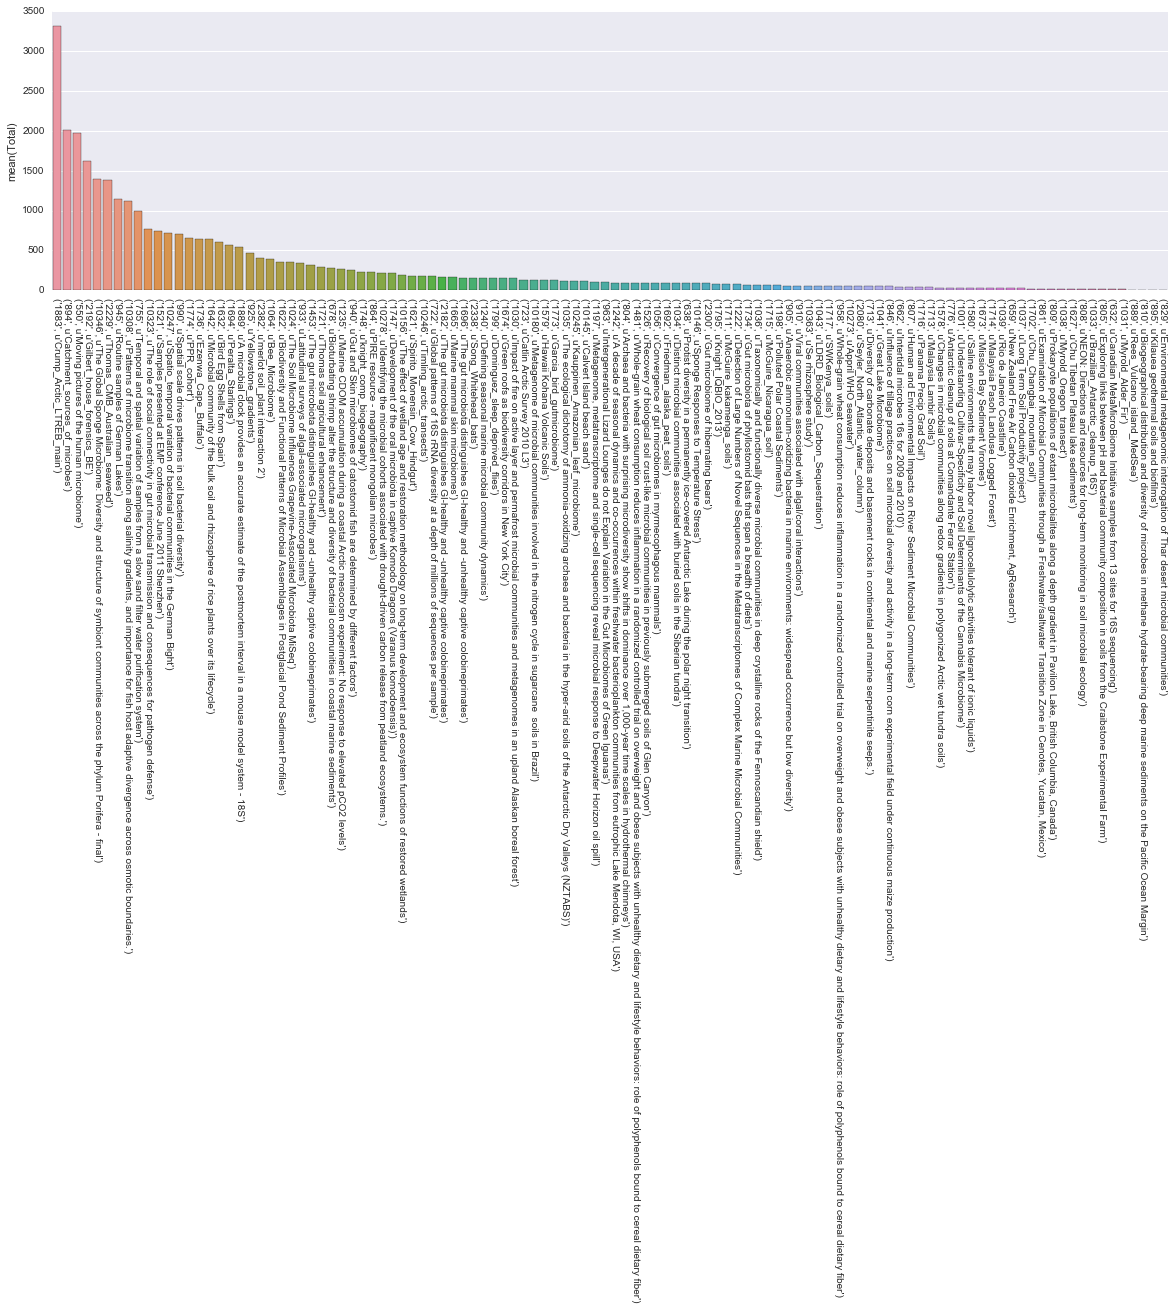

In [54]:
plt.figure(figsize=(20,5))
ph = sns.barplot(studies_groupby_unstack_sorted.index, studies_groupby_unstack_sorted)
for item in ph.get_xticklabels():
    item.set_rotation(270)

### Write merged refined mapping file

In [55]:
df_refined.to_csv('%s/emp_qiime_mapping_refined_%s.tsv' % (path_outputdir, today.strftime('%Y%m%d')), sep='\t')

In [59]:
# write qc_filtered and subset mapping files
df_refined[df_refined.qc_filtered == True].to_csv('%s/emp_qiime_mapping_qc_filtered.tsv' % (path_outputdir), sep='\t')
df_refined[df_refined.subset_10000 == True].to_csv('%s/emp_qiime_mapping_subset_10000.tsv' % (path_outputdir), sep='\t')
df_refined[df_refined.subset_5000 == True].to_csv('%s/emp_qiime_mapping_subset_5000.tsv' % (path_outputdir), sep='\t')
df_refined[df_refined.subset_2000 == True].to_csv('%s/emp_qiime_mapping_subset_2000.tsv' % (path_outputdir), sep='\t')

### Write list of studies

In [57]:
studies_groupby_unstack.to_csv('%s/emp_studies_no_controls_%s.tsv' % (path_outputdir, today.strftime('%Y%m%d')), sep='\t')

### Split and write individual refined mapping files

In [58]:
studies = [line.rstrip('\n') for line in open(path_studies)]
for study in studies:
    df_individual = df_refined[df_refined.study_id == study]
    df_individual.to_csv('%s/qiime-maps-refined/%s_qiime_mapping_refined.tsv' % (path_outputdir, study), sep='\t')